# KdV Solitons
An important equation from the theory of solitons is the Korteweg-deVries (KdV) equation,
$$ \frac{\partial \rho}{\partial t} = -6\rho\frac{\partial \rho}{\partial x} - \frac{\partial^3 \rho}{\partial^3 x} $$
Write a program that solves the KdV equation using the explicit/implicit scheme
$$
\frac{\rho^{n+1}_j-\rho^{n}_j}{\Delta t} = -6D_j\,\rho^n_j-\frac{1}{2}

\Biggl(
\frac{\rho^{n}_{j+2}-2\rho^{n}_{j+1}+2\rho^{n}_{j-1}-\rho^{n}_{j-2}}{2\Delta x^3} + \frac{\rho^{n+1}_{j+2}-2\rho^{n+1}_{j+1}+2\rho^{n+1}_{j-1}-\rho^{n+1}_{j-2}}{2\Delta x^3}
\Biggr)
$$

where
$$
D_j = \frac{\rho^{n}_{j+1}-\rho^{n}_{j-1}}{2\Delta x}
$$

Use the Dirichlet boundary conditions $\rho(x = ±L/2) = 0$. Use the solitary wave solution of the KdV equation as an initial condition, $\rho(x, t) = 2\mbox{sech}^2(x − 4t)$. What do you observe?


Rearranging the implicit/explicit scheme yields:
$$
\rho^{n+1}_j =\rho^{n}_j -3\frac{\Delta t\,}{\Delta x}(\rho^{n}_{j+1}-\rho^{n}_{j-1})\,\rho^n_j
-\frac{\Delta t}{4\Delta x^3}
\bigl(
(\rho^{n}_{j+2}-2\rho^{n}_{j+1}+2\rho^{n}_{j-1}-\rho^{n}_{j-2}) + (\rho^{n+1}_{j+2}-2\rho^{n+1}_{j+1}+2\rho^{n+1}_{j-1}-\rho^{n+1}_{j-2})
\bigr)
$$
We can then fully rearrange so that $\rho^{n+1}$ terms are on the left, and $\rho^{n}$ terms are on the right

$$
\rho^{n+1}_j +\frac{\Delta t}{4\Delta x^3}(\rho^{n+1}_{j+2}-2\rho^{n+1}_{j+1}+2\rho^{n+1}_{j-1}-\rho^{n+1}_{j-2}) =\rho^{n}_j -3\frac{\Delta t\,}{\Delta x}(\rho^{n}_{j+1}-\rho^{n}_{j-1})\,\rho^n_j
-\frac{\Delta t}{4\Delta x^3}
\bigl(
(\rho^{n}_{j+2}-2\rho^{n}_{j+1}+2\rho^{n}_{j-1}-\rho^{n}_{j-2})
\bigr)
$$

We can clean up this expression by writing a vectorized form for all $\rho_j$ at a given timestep $n$.
We write $\rho^{n}$ to mean a column vector of $\rho^n_j$ with the j index disappearing as we are working with all rows at once.

Then we can write operations such as $$(\rho^{n}_{j+2}-2\rho^{n}_{j+1}+2\rho^{n}_{j-1}-\rho^{n}_{j-2})$$ as matrix products on $\rho^n$.
We start with the left hand side, defining
$$\alpha=\frac{\Delta t}{4\Delta x^3}$\mbox{ and } A\rho^{n}_j=(\rho^{n}_{j+2}-2\rho^{n}_{j}+2\rho^{n}_{j-1}-\rho^{n}_{j-2})$$
Where $n$ and $n+1$ are equally valid timesteps on which to apply $ A $ .

We get
$$
\rho^{n+1}_j +\alpha A\rho^{n+1} =\rho^{n}_j -\alpha A \rho^{n}

-3\frac{\Delta t\,}{\Delta x}(\rho^{n}_{j+1}-\rho^{n}_{j-1})\,\rho^n_j

$$

In the interest of bringing this completely, or close to completely in matrix terms, we can notice that $\rho^n_j$ should return itself for each j in the matrix version of the equation. That means we replace$\rho^n_j$ with $I\rho^n$.
Additionally, we have another matrix and prefactor to define.
We define
$$ \beta=3\frac{\Delta t\,}{\Delta x}\mbox{ and } B\rho^n_j = (\rho^{n}_{j+1}-\rho^{n}_{j-1})$$

Simplifying fully, we get

$$
I\rho^{n+1} +\alpha A\rho^{n+1} =I\rho^{n} -\alpha A \rho^{n}-\beta (B\rho^n)\odot\rho^n
$$
Where $\odot$ means the hadamard (element-wise) product rather than the matrix product present in the rest of the equation.

Still, this can be further made matrix-like by noticing
$$
(B\rho^n)\odot\rho^n = \mbox{diag}(\rho^n)B\rho^n
$$

giving
$$
(I +\alpha A)\rho^{n+1} =
\bigl(
I -\alpha A -\beta \mbox{diag}(\rho^n)B
\bigr)\rho^n
$$.

We can finally rearrange using a matrix inverse of $(I +\alpha A)$.

$$
\rho^{n+1} = (I +\alpha A)^{-1}
\bigl(
I -\alpha A -\beta \mbox{diag}(\rho^n)B
\bigr)\rho^n
$$

To obfuscate what we've done behind some incomprehensible notation, we can define
$H = (I +\alpha A)^{-1}$, a quantity we can precompute and only solve for once, and
$F(\rho^{n})=I -\alpha A -\beta \mbox{diag}(\rho^n)B$, a quantity to compute at every time step using the $\rho^n$ from the last time step.

$$
\rho^{n+1} =H\,F(\rho^n)\rho^n
$$
Further splitting to allow for precomputing as much as possible
$$
\rho^{n+1} =H\,(F_{\mbox{same}}+F_{\mbox{diff}}(\rho^n))\rho^n
$$
$$
\rho^{n+1} =H\,F_{\mbox{same}}+H\,F_{\mbox{diff}}(\rho^n)\rho^n
$$

In [169]:
import numpy as np

#parameters
tau=0.001
maxTime=20
tGridNum=int(np.ceil(maxTime/tau)) # we'd rather ceil than floor

L=30 #length
xGridSize=0.01
xGridNum=int(np.ceil(L/(xGridSize))) # integer

bufferSize=0#2 #set equal to the furthest away the derivative looks ahead on either side from the current point
#the discrete derivative we will use looks at most 2 grid locations away

# this buffer is unncessary in the matrix scheme for solving this since matrix multiplication doesn't loop in the same way that array indexing would


#create index of X values for grid locations
N=np.linspace(start=0,stop=xGridNum-1,num=xGridNum)
xGrid=-L/2+(N+1/2)*xGridSize

#create index of time values
tIndices=np.linspace(start=0,stop=tGridNum-1,num=tGridNum) #largely defunct?
tGrid=np.linspace(start=0,stop=tGridNum-1,num=tGridNum)*tau

#create soliton
soliton=2/((np.cosh(xGrid))**2)

#create grid itself

grid=np.zeros((xGridNum+bufferSize,tGridNum))
#the extra (two) rows are out of bounds but can be indexed into from either side when taking the derivative for points at the edge of the simulated region

grid[:,0]=np.concatenate((soliton,np.zeros(bufferSize)))

#enforce boundary conditions
grid[0,0]=0
grid[-(1+bufferSize),0]=0#negative indexing allows me to loop back to the last element on that dimension, though I need to get past the buffer


In [170]:
import scipy
from scipy.sparse import dia_matrix
import scipy.linalg
#compute the constants
alpha=tau/(4*(xGridSize*xGridSize*xGridSize))
beta=3*tau/(xGridSize)
#compute the precomputable matrices

offsetsA=np.array([2,1,-1,-2])
dataA=np.array([np.ones(xGridNum), -2*np.ones(xGridNum),2*np.ones(xGridNum), -np.ones(xGridNum)])
A=dia_matrix((dataA,offsetsA),shape=(xGridNum,xGridNum))

#we don't neet to futz around with getting the diagonal to loop around to the top right edge and get buffer elements, since buffer elements are always set to zero each time step,
#in fact in this scheme the buffer is unecessary, since the contributions that should be zero will be zero
offsetsB=np.array([1,-1])
dataB=np.array([np.ones(xGridNum),-np.ones(xGridNum)])

B = dia_matrix((dataB,offsetsB),shape=(xGridNum,xGridNum))


I=scipy.sparse.identity(xGridNum)
H = scipy.sparse.linalg.inv(scipy.sparse.csr_matrix(I)+alpha*scipy.sparse.csr_matrix(A))

F_same=I-alpha*A
#the first part of F will be the same for all time steps
#begin the loop
HF_same=H@F_same
B=B.tocsr()

#F_diff=-beta*scipy.sparse.diags(grid[:,j-1],0)@B
#HF_diff=H@F_diff
#Full_Advance_operator=HF_same+HF_diff
#grid[:,j]=Full_Advance_operator@grid[:,j-1]


state=grid[:,0]

C:\Users\Robin\.conda\envs\ProfHurst_PHYS240_Sp23\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
C:\Users\Robin\.conda\envs\ProfHurst_PHYS240_Sp23\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [171]:

blowupFrame=tGridNum
for j in range(1,tGridNum):
    F_diff=-beta*scipy.sparse.diags(state,0)@B
    HF_diff=H@F_diff
    Full_Advance_operator=HF_same+HF_diff
    state=Full_Advance_operator@state
    #grid[0,j]=0
    #grid[-1,j]=0
    #enforces boundary conditions? should not do anything as the conditions should be automatically enforced
    grid[:,j]=state
    if j % np.ceil(tGridNum/100) == 0:
        print(f'{j/(tGridNum)*100:.1f} % done')
    if np.isnan(grid[1,j]):
        print('numerical instability caused blowup')
        blowupFrame=j
        break;
print('done')

1.0 % done
2.0 % done
3.0 % done
4.0 % done
5.0 % done
6.0 % done
7.0 % done
8.0 % done
9.0 % done
10.0 % done
11.0 % done
12.0 % done
13.0 % done
14.0 % done
15.0 % done
16.0 % done
17.0 % done
18.0 % done
19.0 % done
20.0 % done
21.0 % done
22.0 % done
23.0 % done
24.0 % done
25.0 % done
26.0 % done
27.0 % done
28.0 % done
29.0 % done
30.0 % done
31.0 % done
32.0 % done
33.0 % done
34.0 % done
35.0 % done
36.0 % done
37.0 % done
38.0 % done
39.0 % done
40.0 % done
41.0 % done
42.0 % done
43.0 % done
44.0 % done
45.0 % done
46.0 % done
47.0 % done
48.0 % done
49.0 % done
50.0 % done
51.0 % done
52.0 % done
53.0 % done
54.0 % done
55.0 % done
56.0 % done
57.0 % done
58.0 % done
59.0 % done
60.0 % done
61.0 % done
62.0 % done
63.0 % done
64.0 % done
65.0 % done
66.0 % done
67.0 % done
68.0 % done
69.0 % done
numerical instability caused blowup
done


Well, the warnings aren't an encouraging sign. They appear because the solution blows up when ripples start to grow to higher and higher frequencies after the soliton collides with the boundary. The high frequency ripples then grow in amplitude and the solution quickly explodes. This occurs faster when the timestep and/or grid size are larger. The grid size seems to be the larger issue, as smaller timestep increases runtime linearly, while smaller $\Delta x$ increases runtime at least quadratically, if not worse.

I switched from numpy arrays to scipy sparse arrays, and that seemed to lead to a ~2x speedup to the computation. It may have slowed down the recording of the video, however. I then changed from accessing the full grid variable when computing to just storing the current state and recording it to the grid after each computation step. Somewhat unsurprisingly, this did not seem to affect runtime.

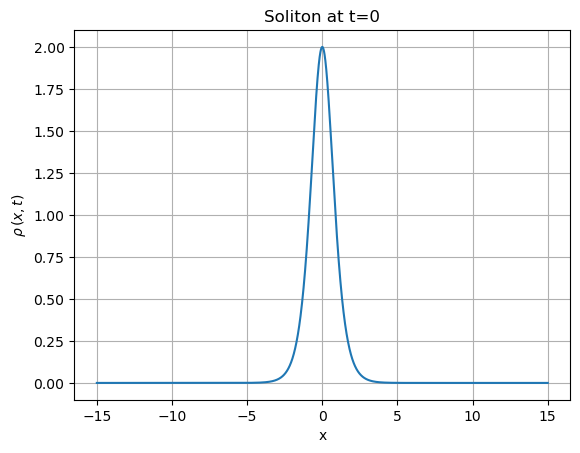

In [172]:

import matplotlib.pyplot as plt
timeStep=0
fig=plt.plot(xGrid,grid[:,timeStep])
plt.title("Soliton at t=0")
plt.xlabel("x")
plt.ylabel("$\\rho\,(x,t)$")
plt.grid(visible=True)

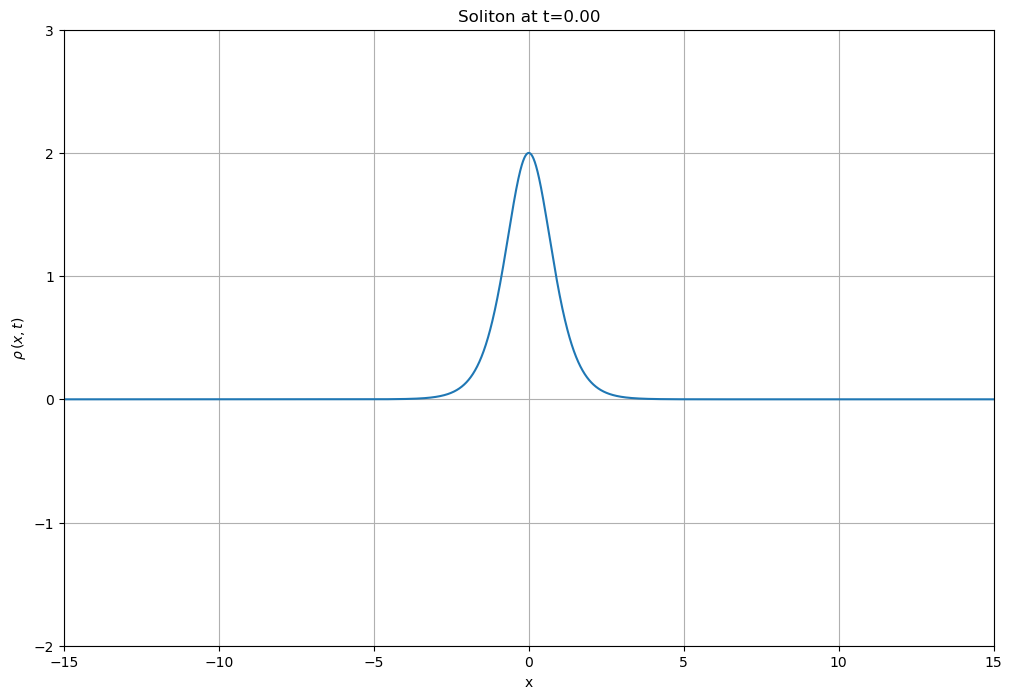

In [173]:
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(12,8))
ax.set(xlim=(-L/2,L/2),ylim=(-2,3))

curve=ax.plot(xGrid,grid[:,0])[0]

plt.xlabel("x")
plt.ylabel("$\\rho\,(x,t)$")
plt.grid(visible=True)
def animateKDV(i):
    plt.title(f"Soliton at t={i*tau:.2f}")
    curve.set_ydata(grid[:,i])

anim=animation.FuncAnimation(fig,animateKDV,interval=1000*tau,frames=min(tGridNum,blowupFrame+100))
anim.save(f'kdv_test_tau={tau}_T={maxTime}_xGridSize={xGridSize}_L={L}.mp4')


Text(0.5, 0, '$\\rho$')

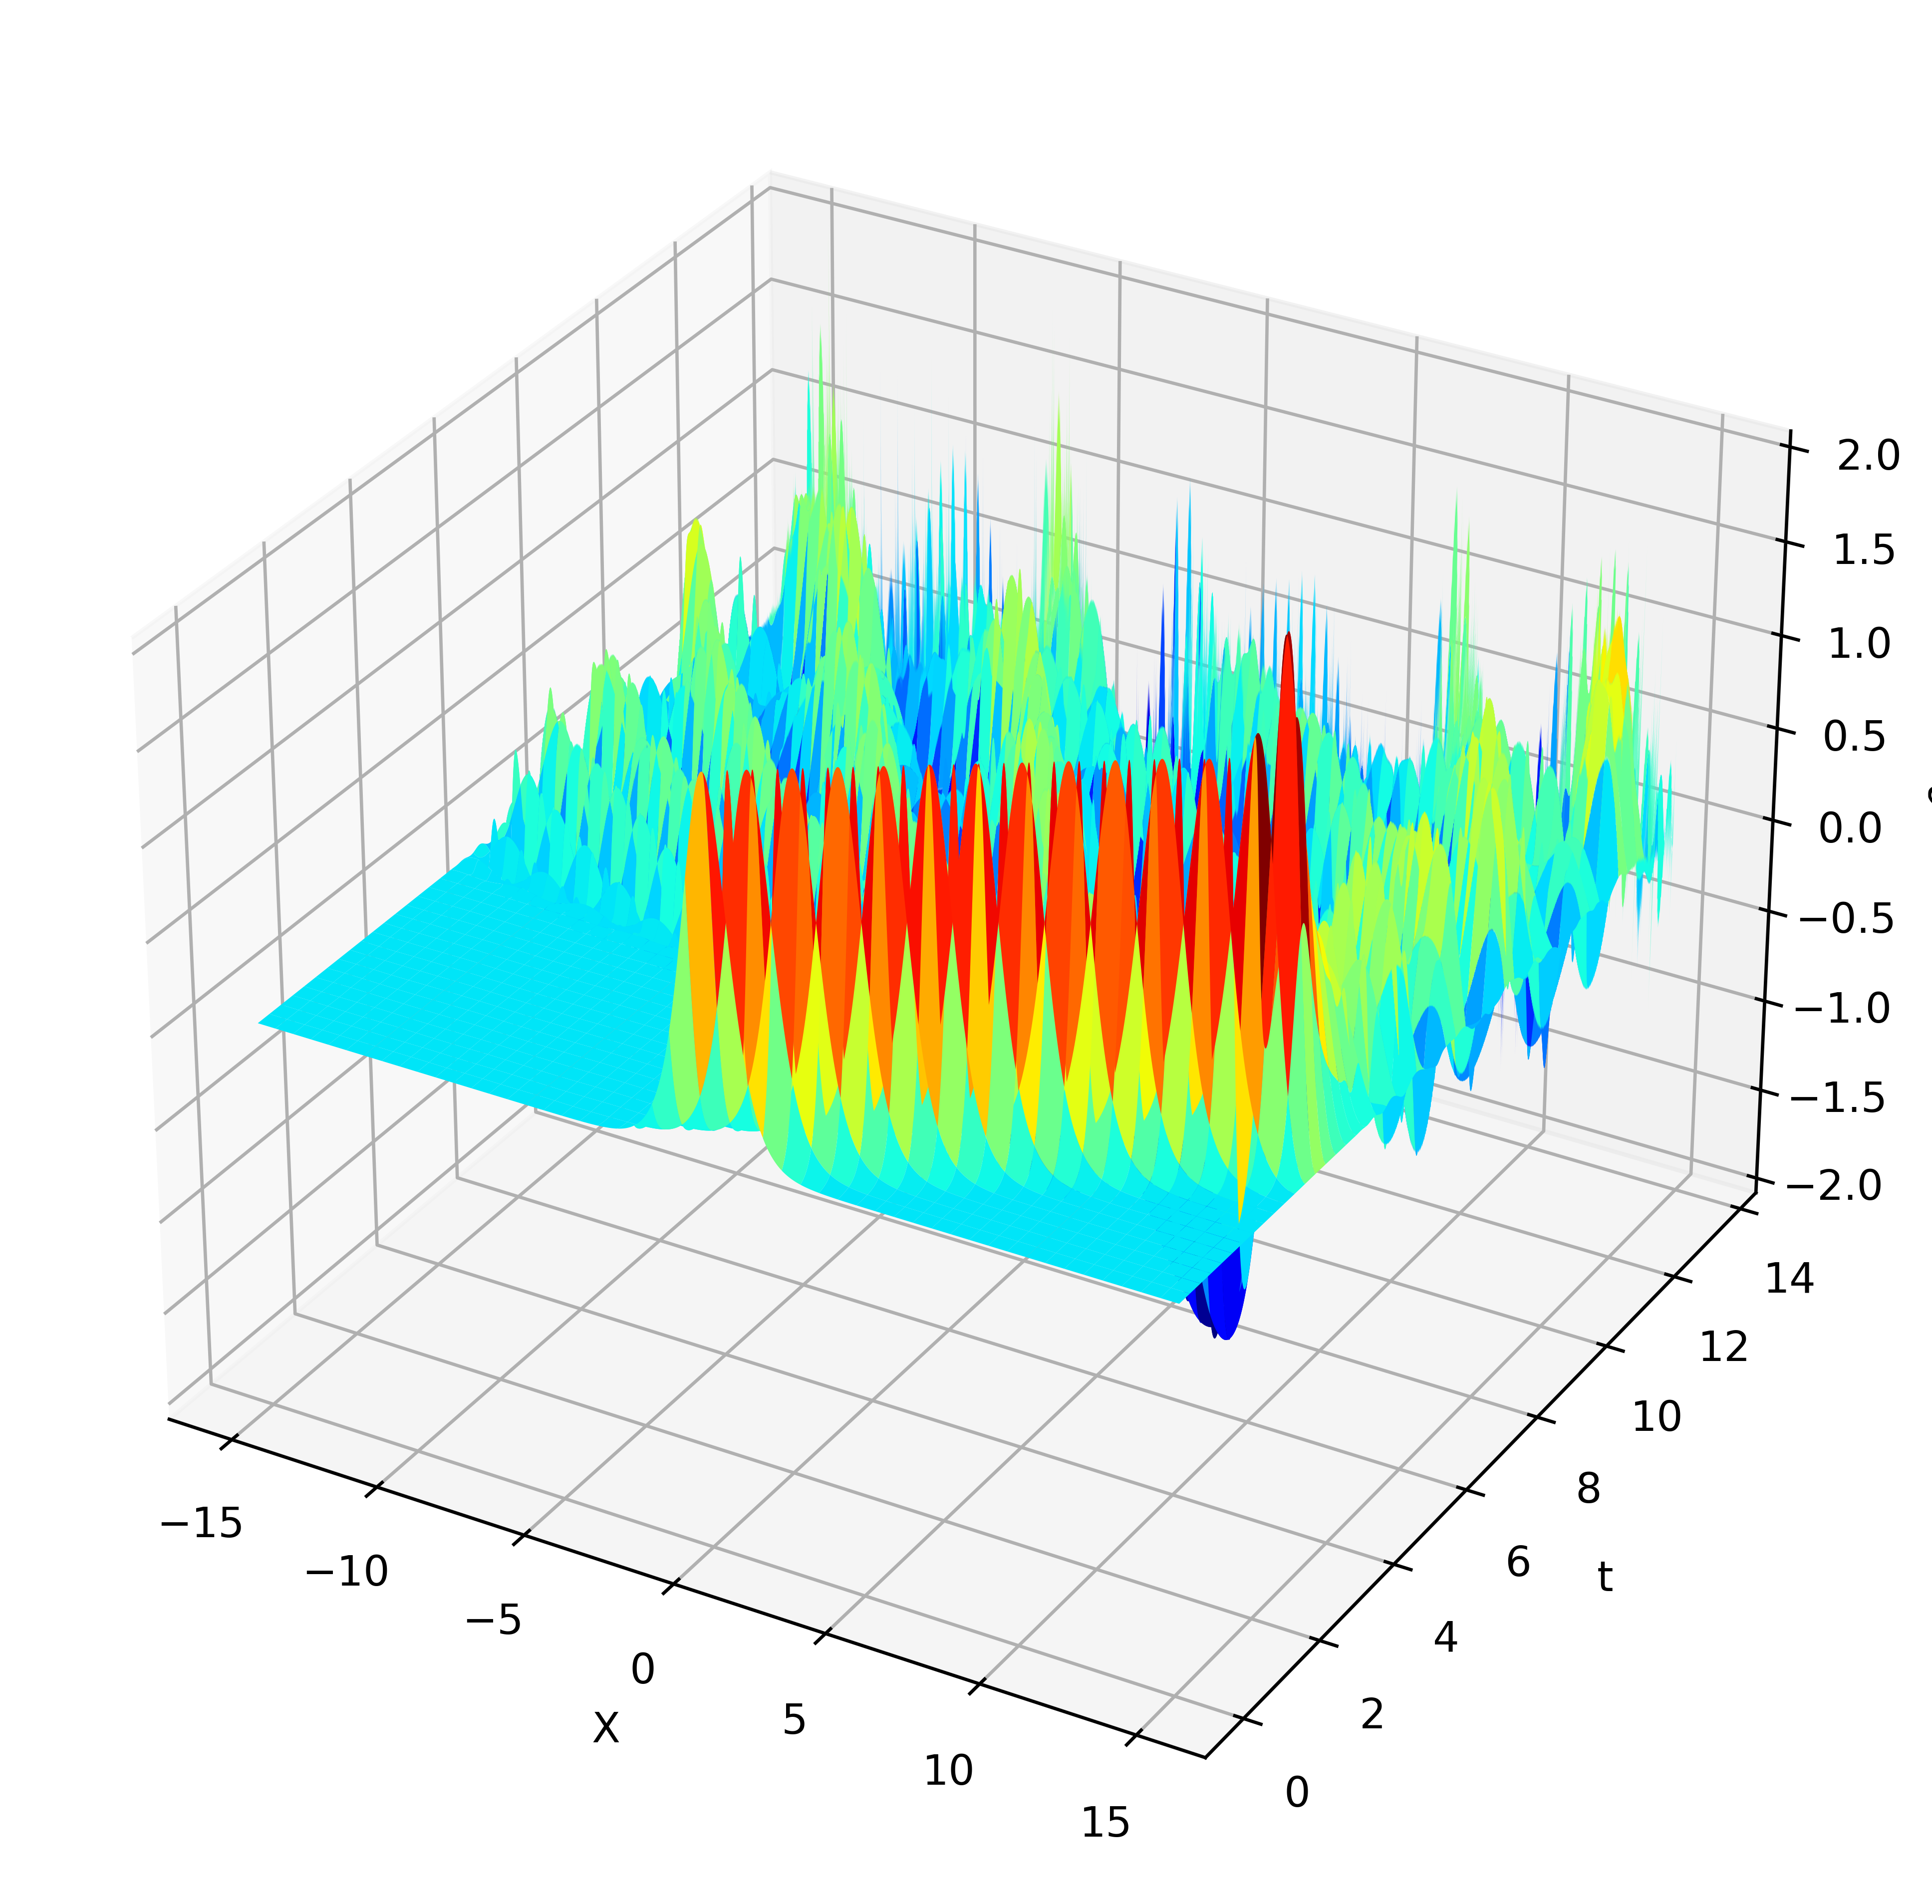

In [213]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(8,8),dpi=600)
X, Y = np.meshgrid(xGrid,tGrid)

timeBuffer=400
endTimeIndex=blowupFrame-timeBuffer

surf = ax.plot_surface(X[0:endTimeIndex,:], Y[0:endTimeIndex,:],np.ndarray.transpose(grid[:,0:endTimeIndex]), cmap=cm.jet, linewidth=0, antialiased=True)
#ax.zaxis.set_major_locator(LinearLocator(10))
ax.set_zlim(-2, 2)
ax.set_xlabel("X")
ax.set_ylabel("t")
ax.set_zlabel(f"$\\rho$")
#ax.view_init(0, 0)

Text(0, 0.5, 't')

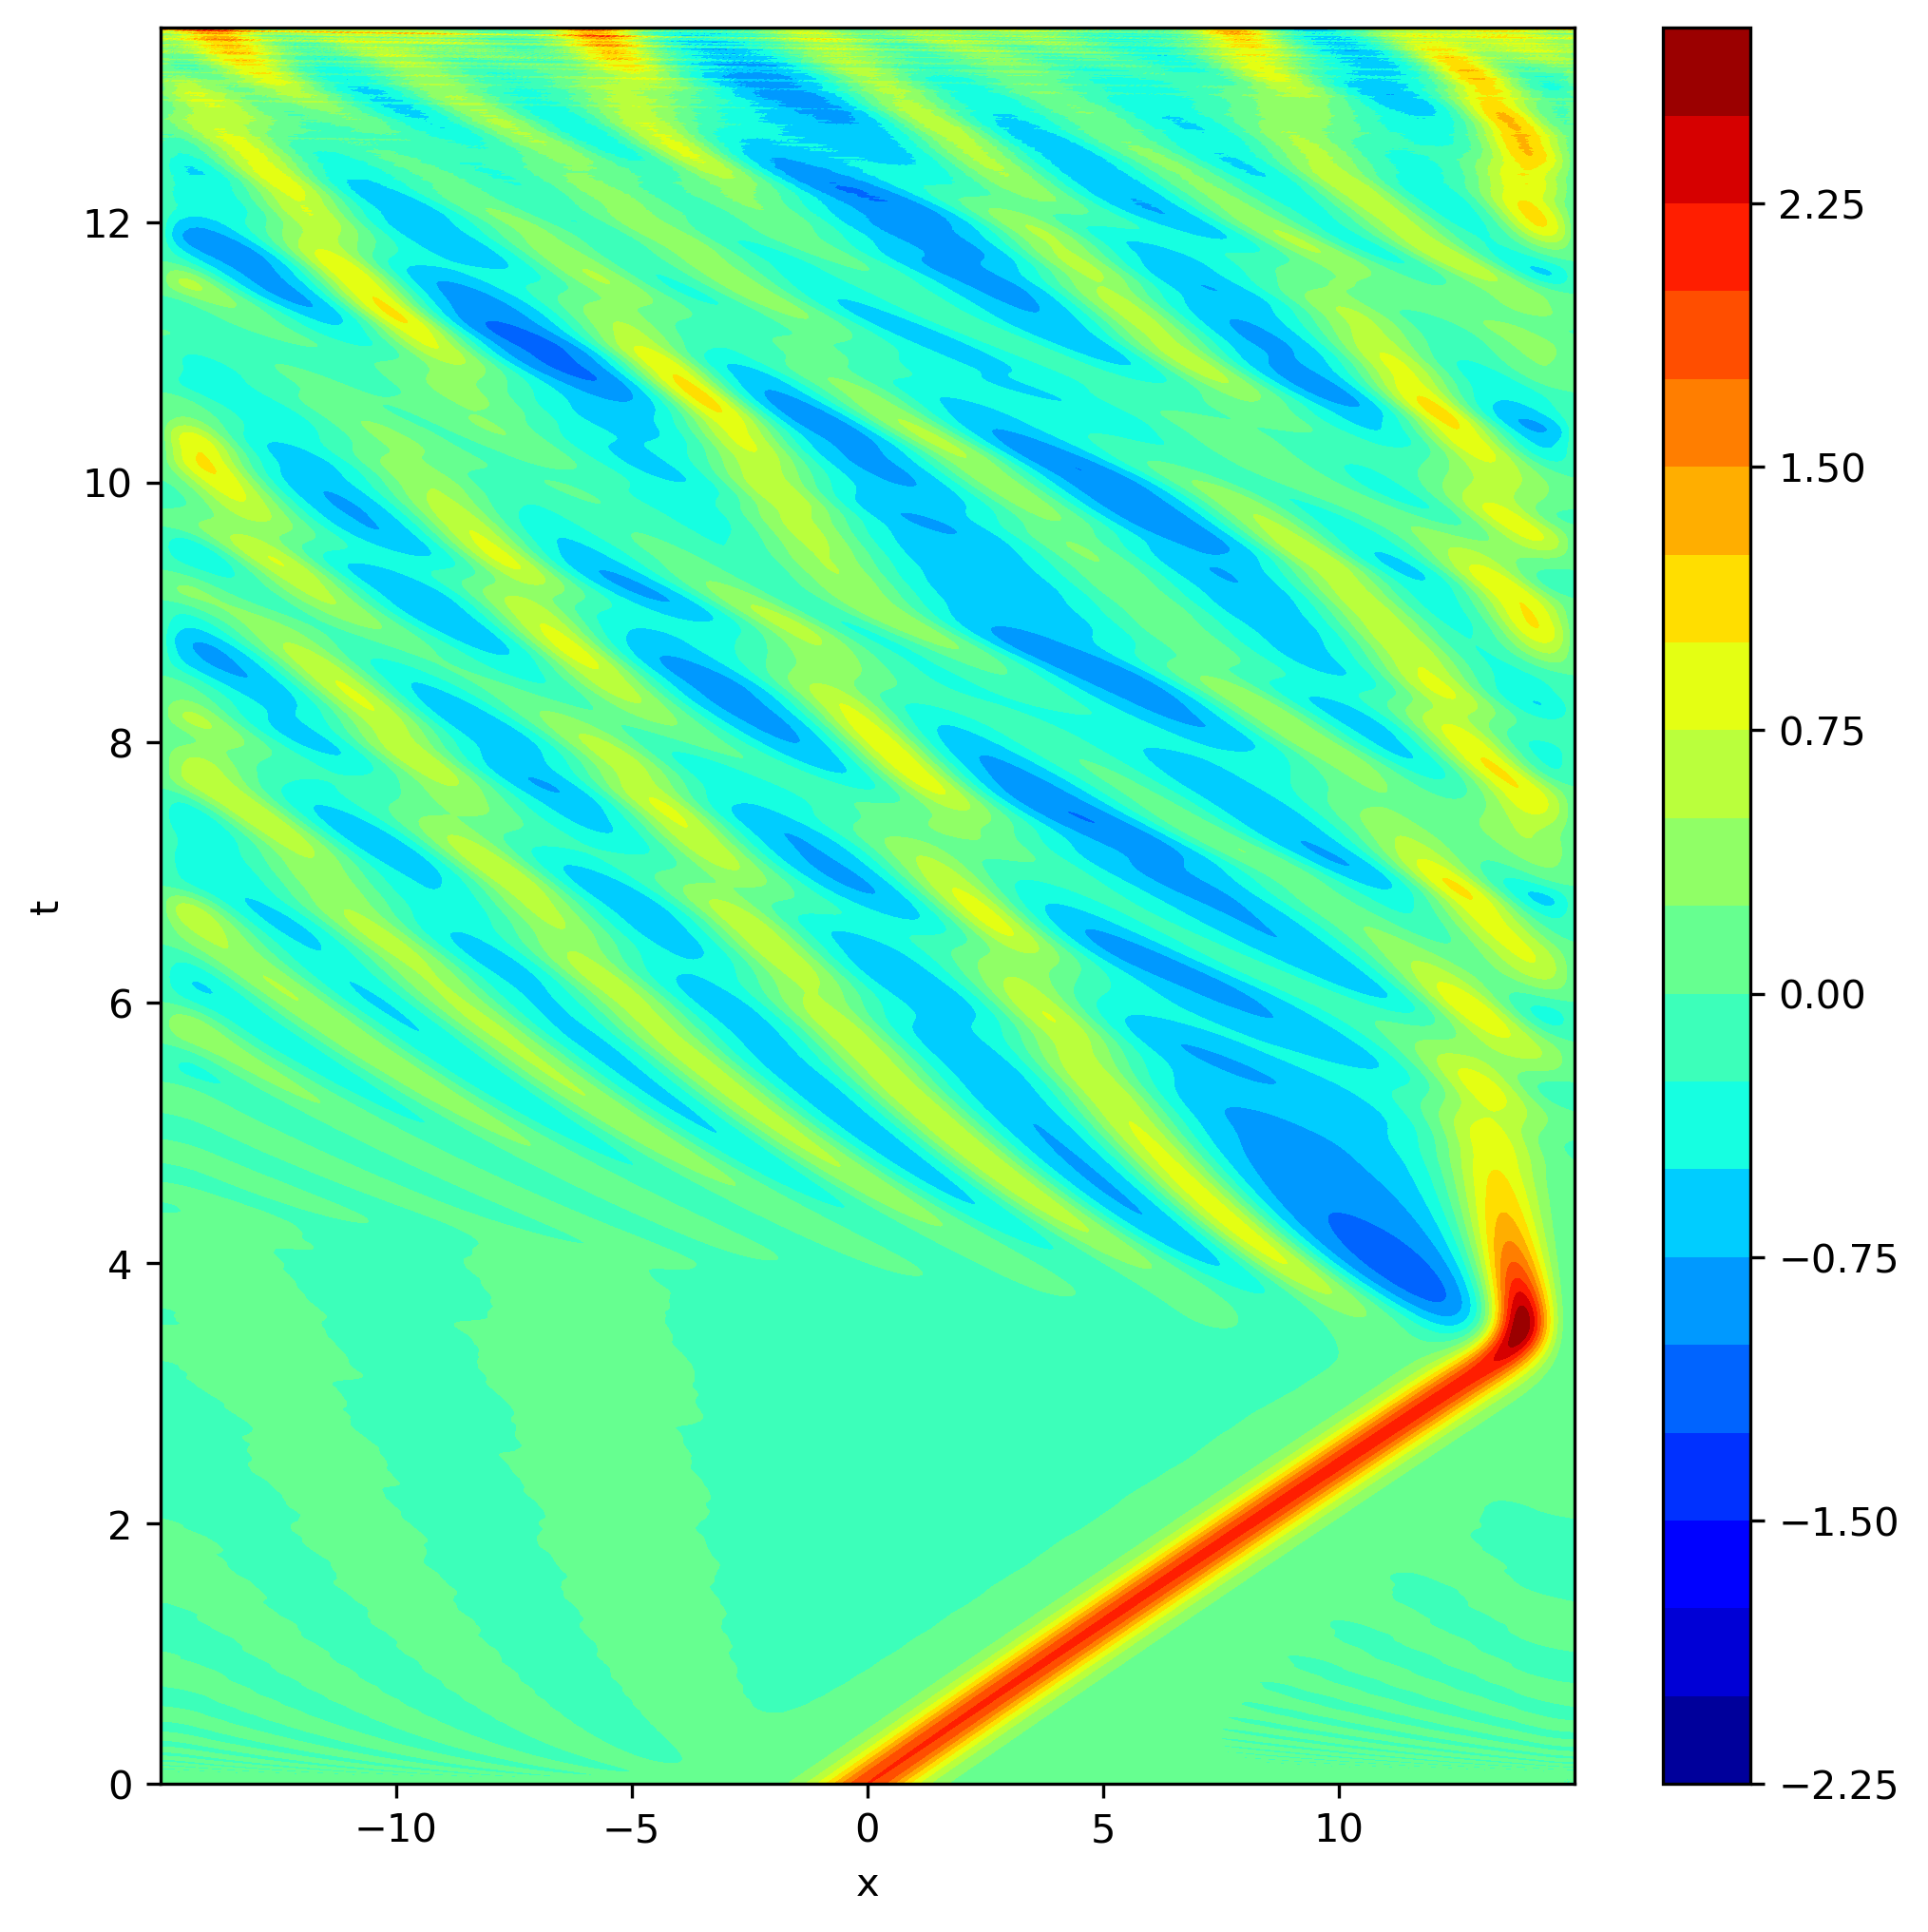

In [222]:
fig, ax = plt.subplots(figsize=(8,8),dpi=300)

plt.contourf(X[0:endTimeIndex,:], Y[0:endTimeIndex,:], np.ndarray.transpose(grid[:,0:endTimeIndex]), 20, cmap=cm.jet)
plt.colorbar();
plt.xlabel("x")
plt.ylabel("t")

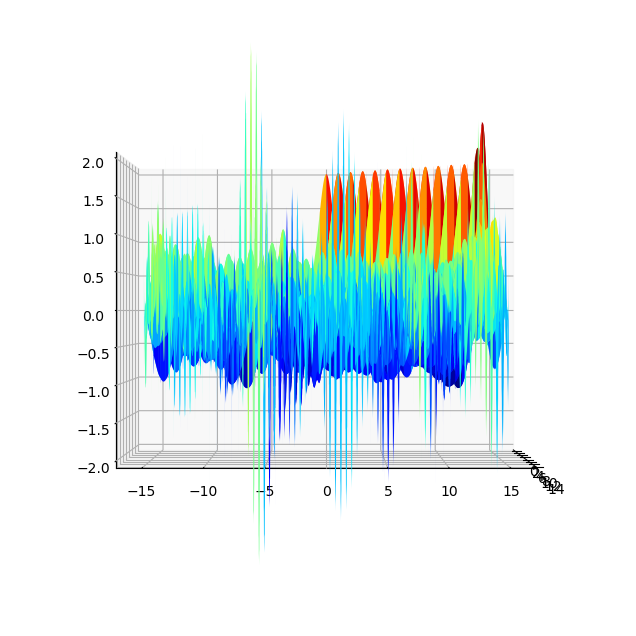

In [201]:

from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(12,8))
X, Y = np.meshgrid(tGrid,xGrid )

timeBuffer=200
endTimeIndex=blowupFrame-timeBuffer

surf = ax.plot_surface(X[:,0:endTimeIndex], Y[:,0:endTimeIndex],grid[:,0:endTimeIndex], cmap=cm.jet, linewidth=0, antialiased=True)
#ax.zaxis.set_major_locator(LinearLocator(10))
ax.set_zlim(-2, 2)

